# Calculation of cross-section for 23Na(p,p)23Na

Uses Gaussian fuctions to automatically fit the peaks observed in the spectra and calculate the cross section for the 23Na(p,p)23Na reaction.

### Imports and constant init

In [17]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from scipy.signal import peak_widths, find_peaks

In [18]:
import warnings

warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [19]:
# File paths
ENERGY_FILE = r"C:\Users\diogo\Documents\Repos\gaussian-spectra-analyser\data\energies.csv"
FOLDER_PATH = r"C:\Users\diogo\Documents\Repos\gaussian-spectra-analyser\data\samples"
COMP_FILE_1 = r"C:\Users\diogo\Documents\Repos\gaussian-spectra-analyser\data\Caciolli.csv"
COMP_FILE_2 = r"C:\Users\diogo\Documents\Repos\gaussian-spectra-analyser\data\Vanhoy.csv"

In [20]:
# Sample info
ANGLE = np.radians(157)
E_SQ = 1.44e-13  # MeV.cm
QUANT_RATIO = (0.502 * 1.025e18) / (0.9 * 3.57e17)
SAMPLE_THICKNESS = 1025  # 10^15 at/cm2
M_FLUORINE = 18.9984  # amu
M_OXYGEN = 15.999  # amu
M_PROTON = 1.0078  # amu
M_SILVER = 107.87  # amu
M_SODIUM = 22.99  # amu
Z_FLUORINE = 9
Z_OXYGEN = 8
Z_PROTON = 1
Z_SILVER = 47
Z_SODIUM = 11

# Adjustment parameters
PARAM_B = 2.76422
PARAM_M = 6.40979
LEFT_THRESHOLD = 70
RIGHT_THRESHOLD = 30
MAX_SPECTRA_CHANNEL = 699

### Reading Files

In [21]:
def read_files(file_counter):
    """Reads all spectrum files in the specified directory"""
    file_name = os.listdir(FOLDER_PATH)
    df_file_readout = pd.read_csv(
        os.path.join(FOLDER_PATH, file_name[file_counter]),
        delimiter=r"\s+",
        header=0,
        names=["channel", "counts"],
    )
    df_file_readout = df_file_readout.iloc[:MAX_SPECTRA_CHANNEL, :MAX_SPECTRA_CHANNEL]
    return df_file_readout


def read_comp_files():
    """Reads IBANDL cross-section files for graph comparison"""
    df_comp1 = pd.read_csv(COMP_FILE_1, delimiter=";")
    df_comp2 = pd.read_csv(COMP_FILE_2, delimiter=";")
    comp1_x = df_comp1["E"].to_list()
    comp1_y = df_comp1["Sig"].to_list()
    comp2_x = df_comp2["E"].to_list()
    comp2_y = df_comp2["Sig"].to_list()
    return comp1_x, comp1_y, comp2_x, comp2_y

### Theoretical Calcs

In [22]:
def kinematic_factor(projectile_mass, target_mass, angle):
    k_factor = (
        (
            np.sqrt(target_mass**2 - projectile_mass**2 * (np.sin(angle)) ** 2)
            + projectile_mass * np.cos(angle)
        )
        / (projectile_mass + target_mass)
    ) ** 2
    return k_factor


def ruth_cross_section(
    projectile_z, target_z, projectile_mass, target_mass, energy, angle
):
    cross_sec = (
        ((projectile_z * target_z * E_SQ / (4 * energy * 1e-3)) ** 2)
        * (4 / np.sin(angle) ** 4)
        * (
            np.cos(angle)
            + np.sqrt(1 - (projectile_mass / target_mass) ** 2 * np.sin(angle) ** 2)
        )
        ** 2
        / np.sqrt(1 - (projectile_mass / target_mass) ** 2 * (np.sin(angle)) ** 2)
    )
    return cross_sec * 1e27

### Function init

In [23]:
def exponential_func(x, a, b):
    return a * np.exp(b * x)


def exp_initial_guess(df_file_readout):
    b = (
        1
        / (df_file_readout["channel"].iloc[200] - df_file_readout["channel"].iloc[25])
        * np.log(
            df_file_readout["counts"].iloc[200] / df_file_readout["counts"].iloc[25]
        )
    )
    return b


def exp_adjustment(df_file_readout):
    b = exp_initial_guess(df_file_readout)

    # noinspection PyTupleAssignmentBalance
    parameters, cov = curve_fit(
        exponential_func,
        df_file_readout["channel"].iloc[25:200],
        df_file_readout["counts"].iloc[25:200],
        p0=[df_file_readout["counts"].iloc[25], b],
    )
    background = [
        exponential_func(x, parameters[0], parameters[1])
        for x in df_file_readout["channel"]
    ]
    return b, parameters, background


def gaussian(x, amp, mean, stddev):
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev**2))


def sum_of_gaussians(x, *parameters):
    y = np.zeros_like(x)
    num_gaussians = len(parameters) // 3
    for i in range(num_gaussians):
        amplitude = parameters[i * 3]
        mean = parameters[i * 3 + 1]
        stddev = parameters[i * 3 + 2]
        y += gaussian(x, amplitude, mean, stddev)
    return y

### Simulation Paramenters

In [24]:
def simulation_params():
    num_samples = input("How many samples to use for test: ")
    if num_samples.lower() == "all":
        num_samples = len(os.listdir(FOLDER_PATH))
    show_graph1 = input("Show exp adjustment graphs? [y|n]: ")
    if show_graph1 == "y":
        show_graph1 = True
    elif show_graph1 == "n":
        show_graph1 = False
    show_graph2 = input("Show individual gauss graphs? [y|n]: ")
    if show_graph2 == "y":
        show_graph2 = True
    elif show_graph2 == "n":
        show_graph2 = False
    return num_samples, show_graph1, show_graph2


def simulation_init():
    df_file_energy = pd.read_csv(
        os.path.join(ENERGY_FILE),
        delimiter=";",
        header=0,
        names=["sample_id", "energy(keV)"],
    )
    df_file_energy["sample_id"] = df_file_energy["sample_id"].str.lower()
    df_output = pd.DataFrame(
        columns=[
            "sample id",
            "energy",
            "exp param a",
            "exp param b",
            "area Ag peak",
            "area Na peak",
            "Ag cross-section",
            "Na cross-section",
        ]
    )

    k_factor_1 = kinematic_factor(
        projectile_mass=M_PROTON, target_mass=M_SILVER, angle=ANGLE
    )
    k_factor_2 = kinematic_factor(
        projectile_mass=M_PROTON, target_mass=M_SODIUM, angle=ANGLE
    )
    return df_file_energy, df_output, k_factor_1, k_factor_2

### More Simulation Calcs

In [25]:
def ag_peak_calcs(df_file_readout, energy, kinematic1, kinematic2):
    cross_section_ruth = ruth_cross_section(
        projectile_z=Z_PROTON,
        target_z=Z_SILVER,
        projectile_mass=M_PROTON,
        target_mass=M_FLUORINE,
        energy=energy,
        angle=ANGLE,
    )

    position_1 = round(
        locate_peaks(
            k_factor=kinematic1,
            energy=energy,
            parameter_m=PARAM_M,
            parameter_b=PARAM_B,
        )
    )
    position_2 = round(
        locate_peaks(
            k_factor=kinematic2,
            energy=energy,
            parameter_m=PARAM_M,
            parameter_b=PARAM_B,
        )
    )

    area_1 = peak_area(
        df_file_readout["channel"], df_file_readout["counts"], position_1
    )
    return cross_section_ruth, position_1, position_2, area_1


def calc_gauss_areas(parameters):
    num_gaussians = len(parameters) // 3
    areas = []
    means = []
    for i in range(num_gaussians):
        amplitude = parameters[i * 3]
        mean = parameters[i * 3 + 1]
        stddev = parameters[i * 3 + 2]
        area = amplitude * np.sqrt(2 * np.pi) * stddev
        areas.append(area)
        means.append(mean)
    return areas, means


def locate_peaks(k_factor, energy, parameter_m, parameter_b):
    peak_energy = energy * k_factor
    centroid = (peak_energy - parameter_b) / parameter_m
    return centroid


def find_closest_mean(means, reference_value):
    differences = np.abs(np.array(means) - reference_value)
    closest_index = np.argmin(differences)
    return closest_index, means[closest_index]


def peak_area(x, y, peak_position):
    x = x.tolist()
    y = y.tolist()
    y_right = y[x.index(peak_position) :]
    y_left = y[: x.index(peak_position) + 1]
    y_left.reverse()

    min_limit = y_left[0]
    max_limit = y_right[0]
    for elem in y_right:
        if elem < RIGHT_THRESHOLD:
            max_limit = y_right.index(elem) + len(y_left)
            break
    for elem in y_left:
        if elem < LEFT_THRESHOLD:
            rev_min_limit = y_left.index(elem)
            min_limit = len(y_left) - 1 - rev_min_limit
            break

    area = sum(y[int(min_limit) : int(max_limit)])
    return area

In [26]:
def cross_section(area1, area2, known_cross_section):
    if area2 != 0:
        peak_area_ratio = area1 / area2
        return peak_area_ratio / QUANT_RATIO * known_cross_section
    else:
        return 0


def find_max_min(df_file_readout, background, position2):
    df_file_readout["counts"] = df_file_readout["counts"] - background

    peak_position, _ = find_peaks(df_file_readout["counts"], prominence=30, distance=5)
    peak_position_sub = [i for i in peak_position if i > (position2 - 100)]
    minima_position, _ = find_peaks(
        df_file_readout["counts"] * -1, prominence=30, distance=5
    )
    minima_position_sub = [i for i in minima_position if i > (position2 - 100)]

    peak_value = [df_file_readout["counts"][i] for i in peak_position_sub]
    minima_value = [df_file_readout["counts"][i] for i in minima_position_sub]
    peak_width = peak_widths(
        df_file_readout["counts"], peak_position_sub, rel_height=0.5
    )[0]
    return (
        df_file_readout,
        peak_position_sub,
        minima_position_sub,
        peak_value,
        minima_value,
        peak_width,
    )


def fit_gaussians(df_file_readout, peak_position_sub, df_output, position2, counter):
    initial_guesses = []
    for i in range(len(peak_position_sub)):
        amplitude_guess = peak_counts[i]
        mean_guess = df_file_readout["channel"][peak_position_sub[i]]
        stddev_guess = peak_fwhm[i] / (2 * np.sqrt(2 * np.log(2)))
        initial_guesses.extend([amplitude_guess, mean_guess, stddev_guess])

    try:
        # noinspection PyTupleAssignmentBalance
        popt, covariance = curve_fit(
            sum_of_gaussians,
            df_file_readout["channel"],
            df_file_readout["counts"],
            p0=initial_guesses,
        )
    except RuntimeError:
        popt = None

    if popt is not None:
        gaussian_fit = sum_of_gaussians(df_file_readout["channel"], *popt)
        gauss_areas, gauss_means = calc_gauss_areas(popt)
        closest_channel, closest_mean = find_closest_mean(gauss_means, position2)
        area1 = round(gauss_areas[closest_channel], 2)
        df_output.loc[counter, "area Na peak"] = area1
        return area1, gaussian_fit
    else:
        gaussian_fit = None
        area1 = np.nan
        return area1, gaussian_fit

### Running Simulation

In [ ]:
sample_counter = 0
successful_fits = 0
n_samples, show_exp_adjust, show_individual = simulation_params()
df_file_energy_add, df_sample_output, k_factor_Ag, k_factor_Na = simulation_init()

for _ in tqdm(range(0, int(n_samples)), leave=True, dynamic_ncols=False):
    df_graph_data_readout = read_files(sample_counter)
    sample_energy = df_file_energy_add["energy(keV)"].iloc[sample_counter]
    current_sample = os.listdir(FOLDER_PATH)[sample_counter]

    # Calculates peak positions and Ag info
    Ag_cross_section, position_Ag, position_Na, area_Ag = ag_peak_calcs(
        df_graph_data_readout, sample_energy, k_factor_Ag, k_factor_Na
    )
    initial_b, params, background_fit = exp_adjustment(
        df_graph_data_readout
    )  # Calculates the best exp func

    new_data_row = pd.DataFrame(
        {
            "sample id": [current_sample],
            "energy": [sample_energy],
            "exp param a": [df_graph_data_readout["counts"].iloc[25]],
            "exp param b": [initial_b],
            "area Ag peak": [area_Ag],
            "area Na peak": [np.nan],
            "Ag cross-section": [Ag_cross_section],
            "Na cross-section": [np.nan],
        }
    )
    df_sample_output = pd.concat(
        [df_sample_output, new_data_row], ignore_index=True
    )

    if show_exp_adjust:  # Exp adjustment graph
        plt.scatter(
            df_graph_data_readout["channel"],
            df_graph_data_readout["counts"],
            label="Data",
        )
        plt.scatter(
            position_Ag,
            df_graph_data_readout["counts"].iloc[position_Ag],
            label="Ag peak",
            marker="*",
        )
        plt.scatter(
            position_Na,
            df_graph_data_readout["counts"].iloc[position_Na],
            label="Na peak",
            marker="*",
        )
        plt.plot(
            df_graph_data_readout["channel"],
            background_fit,
            color="r",
            label="Exponential fit",
        )
        plt.title(current_sample)
        plt.xlabel("Channel")
        plt.ylabel("Counts")
        plt.legend()
        plt.yscale("log")
        plt.ylim(bottom=1, top=100_000)
        plt.show()

    # Removing background and finding peaks
    (
        df_graph_data_readout,
        peaks_sub,
        minima_sub,
        peak_counts,
        minima_counts,
        peak_fwhm,
    ) = find_max_min(df_graph_data_readout, background_fit, position_Na)

    # Fitting Gaussians
    area_Na, fit = fit_gaussians(df_graph_data_readout, peaks_sub, df_sample_output, position_Na, sample_counter)

    if area_Ag < 100:
        # tqdm.write(
        #     f"WARNING: area_Ag is too low. Unable to calculate cross-section for sample {current_sample}"
        # )
        sample_counter += 1
        continue
    elif area_Na is None or fit is None:
        # tqdm.write(f"WARNING: Unable to fit {current_sample}.")
        sample_counter += 1
        continue
    else:
        Na_cross_section = cross_section(area_Na, area_Ag, Ag_cross_section)
        df_sample_output.loc[sample_counter, "Na cross-section"] = Na_cross_section

    if show_individual:
        plt.scatter(
            df_graph_data_readout["channel"],
            df_graph_data_readout["counts"],
            label="Data",
        )
        plt.scatter(
            position_Ag,
            df_graph_data_readout["counts"].iloc[position_Ag],
            label="Ag peak",
            marker="*",
        )
        plt.scatter(
            position_Na,
            df_graph_data_readout["counts"].iloc[position_Na],
            label="Na peak",
            marker="*",
        )
        plt.plot(
            df_graph_data_readout["channel"], fit, label="Gauss fit", color="r"
        )
        plt.title(current_sample + "(removed exp background)")
        plt.xlabel("Channel")
        plt.ylabel("Counts")
        plt.legend()
        plt.yscale("log")
        plt.ylim(bottom=1, top=100_000)
        plt.show()

    sample_counter += 1
    successful_fits += 1

print(f"Finished analysis. Successfully fitted {successful_fits} samples!")

100%|██████████| 368/368 [21:39<00:00,  3.53s/it] 

Finished analysis. Successfully fitted 362 samples!


### Plotting Results

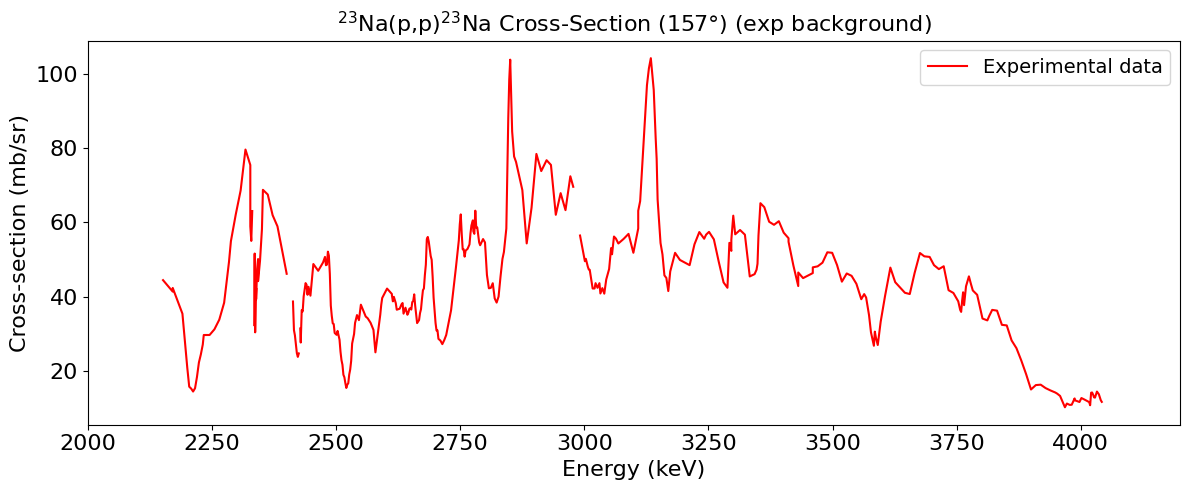

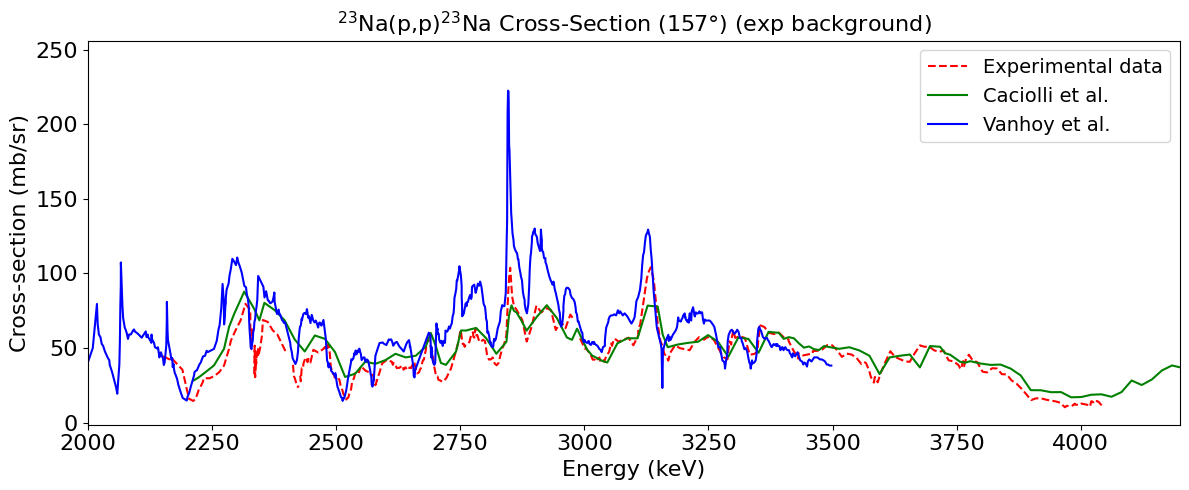

In [28]:
df_sample_output.to_csv(
    os.path.join(
        r"C:\Users\diogo\Documents\Repos\gaussian-spectra-analyser", "output.csv"
    ),
    sep=";",
)
df_sample_output_sorted = df_sample_output.sort_values(
    by="energy", ascending=True
)  # Sorts by ascending energy

# Plotting final excitation function graph
Caciolli_x, Caciolli_y, Vanhoy_x, Vanhoy_y = read_comp_files()

plt.figure(figsize=(12, 5))

plt.plot(
    df_sample_output_sorted["energy"],
    df_sample_output_sorted["Na cross-section"],
    label="Experimental data",
    color="r",
)
plt.title(
    r"$^{23}$Na(p,p)$^{23}$Na Cross-Section (157$\degree$) (exp background)",
    fontsize=16,
)
plt.legend(fontsize=14)
plt.xlabel("Energy (keV)", fontsize=16)
plt.ylabel("Cross-section (mb/sr)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(left=2000, right=4200)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

plt.plot(
    df_sample_output_sorted["energy"],
    df_sample_output_sorted["Na cross-section"],
    label="Experimental data",
    linestyle="--",
    color="r",
)
plt.plot(Caciolli_x, Caciolli_y, label="Caciolli et al.", color="g")
plt.plot(Vanhoy_x, Vanhoy_y, label="Vanhoy et al.", color="b")
plt.title(
    r"$^{23}$Na(p,p)$^{23}$Na Cross-Section (157$\degree$) (exp background)",
    fontsize=16,
)
plt.legend(fontsize=14)
plt.xlabel("Energy (keV)", fontsize=16)
plt.ylabel("Cross-section (mb/sr)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(left=2000, right=4200)
plt.tight_layout()
plt.show()